In [0]:
import pandas as pd
from pyspark.sql.functions import *
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline, Model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler,StandardScaler
from pyspark.ml.classification import LinearSVC,OneVsRest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


## Read data for machine learning analysis <br>
processed in Cleaning&Prepping_Data notebook

In [0]:
yankees_df = spark.read.parquet("/FileStore/yankees/yankees_df_ml.parquet")

In [0]:
## delete na rows
yankees_df = yankees_df.dropna()


In [0]:
yankees_df.printSchema()


root
 |-- num_comments: long (nullable = true)
 |-- W/L: string (nullable = true)
 |-- comment_length: integer (nullable = true)
 |-- gilded_cm: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- sentiment_result: string (nullable = true)
 |-- score_cm: long (nullable = true)
 |-- score: long (nullable = true)
 |-- Opp: string (nullable = true)
 |-- R: long (nullable = true)
 |-- game_length: float (nullable = true)
 |-- D/N: string (nullable = true)
 |-- attendance: double (nullable = true)
 |-- cLI: double (nullable = true)
 |-- game_location: string (nullable = true)



In [0]:
yankees_df.count()

Out[5]: 619333

In [0]:
#yankees_df = yankees_df.filter(yankees_df.sentiment_result != 'neutral')

In [0]:
## sample a small dataset
small_yankees_df = yankees_df.sample(withReplacement=True, fraction=0.01, seed=3)
small_yankees_df.count()

Out[3]: 6201

## Data processing for Support Vector Machine and Random Forest
<!-- We are going to apply support vector machine (SVM) on the data to predict game results (win/loss). SVM requires numeric features. Thus, we are going to convert our categorical variables into dummy variables. Those variables include sentiment_result, Opp, D_N, game_location. -->
Since SVM and Random Forest do not work well on imbalanced data, we need first check the balance of the data.

### Check imbalance data

In [0]:
yankees_df.groupby('W/L').count().collect()

Out[296]: [Row(W/L='L', count=259225), Row(W/L='W', count=360108)]

In [0]:
yankees_df.groupby('sentiment_result').count().collect()

Out[297]: [Row(sentiment_result='positive', count=221101),
 Row(sentiment_result='neutral', count=31770),
 Row(sentiment_result='negative', count=366462)]

In [0]:
yankees_df.groupby('Opp').count().collect()

Out[298]: [Row(Opp='NYM', count=16824),
 Row(Opp='OAK', count=26636),
 Row(Opp='TBR', count=81847),
 Row(Opp='DET', count=16662),
 Row(Opp='BAL', count=66306),
 Row(Opp='BOS', count=78542),
 Row(Opp='KCR', count=27317),
 Row(Opp='TOR', count=63117),
 Row(Opp='LAA', count=25644),
 Row(Opp='CLE', count=18663),
 Row(Opp='CHW', count=31783),
 Row(Opp='MIN', count=25569),
 Row(Opp='ATL', count=19672),
 Row(Opp='PHI', count=16922),
 Row(Opp='HOU', count=34504),
 Row(Opp='SEA', count=25814),
 Row(Opp='MIA', count=14540),
 Row(Opp='TEX', count=17960),
 Row(Opp='WSN', count=11011)]

In [0]:
yankees_df.groupby('game_location').count().collect()

Out[299]: [Row(game_location='away', count=289761),
 Row(game_location='home', count=329572)]

Dealing with imbalanced data <br>
https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/<br>
Example:
"
For  heart stroke example:

n_samples=  43400,  n_classes= 2(0&1), n_sample0= 42617, n_samples1= 783

Weights for class 0:

w0=  43400/(2*42617) = 0.509

Weights for class 1:

w1= 43400/(2*783) = 27.713 "
<br><br><br>


Our case:
[Row(sentiment_result='positive', count=221101),
 Row(sentiment_result='neutral', count=31770),
 Row(sentiment_result='negative', count=366462)]

n_samples=  6201,  n_classes= 3(positive, negative, neutral), n_sample(positive)= 221101, n_samples(neutral)= 31770,n_samples(neutral)= 366462

Weights for class positive:

w0=  619333/(3*221101) = 0.934

Weights for class neutral:

w1= 619333/(3*31770) = 6.50


Weights for class negative:

w2= 619333/(3*366462) = 0.56

In [0]:
## add a weight col to handle imbalance
yankees_df = yankees_df.withColumn('weight', when(col('sentiment_result') == 'positive', 0.934)\
                                               .when(col('sentiment_result') == 'neutral',  6.50)
    .otherwise(0.56) ) 
yankees_df.select('sentiment_result','weight').show(10)

+----------------+------+
|sentiment_result|weight|
+----------------+------+
|         neutral|   6.5|
|        negative|  0.56|
|        positive| 0.934|
|        negative|  0.56|
|        negative|  0.56|
|        positive| 0.934|
|        positive| 0.934|
|        negative|  0.56|
|        negative|  0.56|
|        negative|  0.56|
+----------------+------+
only showing top 10 rows



## Build pipeline for Random Forest model

### Split data into train, test, and split

In [0]:
train_data, test_data, predict_data = yankees_df.randomSplit([0.8, 0.18, 0.02], 24)


In [0]:
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
print("Number of prediction records : " + str(predict_data.count()))

Number of training records: 495675
Number of testing records : 111376
Number of prediction records : 12282


###Create pipeline and train a model

### Random Forest

### The ordering behavior is controlled by setting stringOrderType. Its default value is ‘frequencyDesc’

In [0]:
stringIndexer_WL = StringIndexer(inputCol="W/L", outputCol="WL_ix")
stringIndexer_sentiment= StringIndexer(inputCol="sentiment_result", outputCol="sentiment_ix")
stringIndexer_Opp = StringIndexer(inputCol="Opp", outputCol="Opp_ix")
stringIndexer_DN = StringIndexer(inputCol="D/N", outputCol="DN_ix")
stringIndexer_game_location = StringIndexer(inputCol="game_location", outputCol="game_location_ix")

In [0]:
onehot_WL = OneHotEncoder(inputCol="WL_ix", outputCol="WL_vec")
onehot_sentiment = OneHotEncoder(inputCol="sentiment_ix", outputCol="sentiment_vec")
onehot_Opp = OneHotEncoder(inputCol="Opp_ix", outputCol="Opp_vec")
onehot_DN = OneHotEncoder(inputCol="DN_ix", outputCol="DN_vec")
onehot_game_location = OneHotEncoder(inputCol="game_location_ix", outputCol="game_location_vec")

In [0]:
vectorAssembler_features = VectorAssembler(
    inputCols=['comment_length','gilded_cm','controversiality','score_cm', 'score', 'R','game_length','attendance','cLI','WL_vec','Opp_vec','DN_vec','game_location_vec'], 
    outputCol= "features")

In [0]:
rf = RandomForestClassifier(labelCol="sentiment_ix", featuresCol="features", numTrees=2000, weightCol='weight', impurity='entropy')


In [0]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedSentiment",
                              labels = ['negative', 'positive', 'neutral'])

In [0]:
pipeline_rf = Pipeline(stages=[stringIndexer_WL,
                               stringIndexer_Opp,
                               stringIndexer_DN,
                               stringIndexer_game_location,
                               stringIndexer_sentiment,
                               onehot_WL,
                               onehot_DN,
                               onehot_Opp,
                               onehot_game_location,
                               onehot_sentiment,
                               vectorAssembler_features,
                               rf, labelConverter])

In [0]:
train_data.printSchema()

root
 |-- num_comments: long (nullable = true)
 |-- W/L: string (nullable = true)
 |-- comment_length: integer (nullable = true)
 |-- gilded_cm: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- sentiment_result: string (nullable = true)
 |-- score_cm: long (nullable = true)
 |-- score: long (nullable = true)
 |-- Opp: string (nullable = true)
 |-- R: long (nullable = true)
 |-- game_length: float (nullable = true)
 |-- D/N: string (nullable = true)
 |-- attendance: double (nullable = true)
 |-- cLI: double (nullable = true)
 |-- game_location: string (nullable = true)
 |-- weight: double (nullable = false)



In [0]:
train_data.show(10)

+------------+---+--------------+---------+----------------+----------------+--------+-----+---+---+-----------+---+----------+----+-------------+------+
|num_comments|W/L|comment_length|gilded_cm|controversiality|sentiment_result|score_cm|score|Opp|  R|game_length|D/N|attendance| cLI|game_location|weight|
+------------+---+--------------+---------+----------------+----------------+--------+-----+---+---+-----------+---+----------+----+-------------+------+
|        1488|  L|             1|        0|               0|        positive|       1|   30|SEA|  0|       2.27|  D|   17524.0|0.79|         home| 0.934|
|        1488|  L|             1|        0|               0|        positive|       2|   30|SEA|  0|       2.27|  D|   17524.0|0.79|         home| 0.934|
|        1488|  L|             2|        0|               0|        negative|       1|   30|SEA|  0|       2.27|  D|   17524.0|0.79|         home|  0.56|
|        1488|  L|             2|        0|               0|        negative

In [0]:
model_rf = pipeline_rf.fit(train_data)

###Model Test Results

In [0]:
predictions = model_rf.transform(test_data)

In [0]:
predictions.show()

+------------+---+--------------+---------+----------------+----------------+--------+-----+---+---+-----------+---+----------+----+-------------+------+-----+------+-----+----------------+------------+---------+---------+--------------+-----------------+-------------+--------------------+--------------------+--------------------+----------+------------------+
|num_comments|W/L|comment_length|gilded_cm|controversiality|sentiment_result|score_cm|score|Opp|  R|game_length|D/N|attendance| cLI|game_location|weight|WL_ix|Opp_ix|DN_ix|game_location_ix|sentiment_ix|   WL_vec|   DN_vec|       Opp_vec|game_location_vec|sentiment_vec|            features|       rawPrediction|         probability|prediction|predictedSentiment|
+------------+---+--------------+---------+----------------+----------------+--------+-----+---+---+-----------+---+----------+----+-------------+------+-----+------+-----+----------------+------------+---------+---------+--------------+-----------------+-------------+-----

In [0]:
evaluatorRF = MulticlassClassificationEvaluator(labelCol="sentiment_ix", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)

In [0]:
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.525266
Test Error = 0.474734


In [0]:
predictions_train = model_rf.transform(train_data)

In [0]:
evaluatorRF = MulticlassClassificationEvaluator(labelCol="sentiment_ix", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions_train)

In [0]:
print("Accuracy = %g" % accuracy)
print("Train Error = %g" % (1.0 - accuracy))

Accuracy = 0.52765
Train Error = 0.47235


###Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
predictions.show()

+------------+---+--------------+---------+----------------+----------------+--------+-----+---+---+-----------+---+----------+----+-------------+-----+------+-----+----------------+------------+-------------+-------------+---------------+-----------------+-------------+--------------------+--------------------+--------------------+----------+------------------+
|num_comments|W/L|comment_length|gilded_cm|controversiality|sentiment_result|score_cm|score|Opp|  R|game_length|D/N|attendance| cLI|game_location|WL_ix|Opp_ix|DN_ix|game_location_ix|sentiment_ix|       WL_vec|       DN_vec|        Opp_vec|game_location_vec|sentiment_vec|            features|       rawPrediction|         probability|prediction|predictedSentiment|
+------------+---+--------------+---------+----------------+----------------+--------+-----+---+---+-----------+---+----------+----+-------------+-----+------+-----+----------------+------------+-------------+-------------+---------------+-----------------+-------------

In [0]:
y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("sentiment_ix").collect()

In [0]:
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[40584 20790  4366]
 [18817 17039  3982]
 [ 2799  2120   879]]


In [0]:
## confusion matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize': 20, 'fontweight': 'bold'}, pad=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontdict={'fontsize': 19, 'fontweight': 'bold'})
    plt.xlabel('Predicted label',fontdict={'fontsize': 19, 'fontweight': 'bold'}, labelpad=20)

In [0]:
class_names = ['negative','positive','neutral']

Confusion matrix, without normalization
[[40584 20790  4366]
 [18817 17039  3982]
 [ 2799  2120   879]]


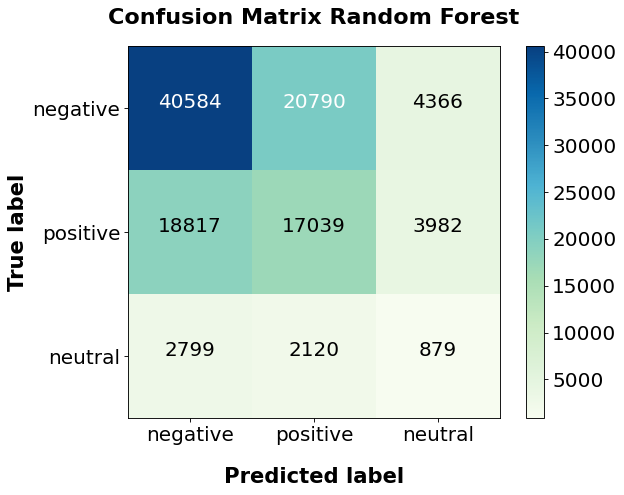

In [0]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

plot_confusion_matrix(cm, classes=class_names,title='Confusion Matrix Random Forest',cmap='GnBu')

### f1 score

In [0]:
evaluator_rf = MulticlassClassificationEvaluator(labelCol="sentiment_ix", predictionCol="prediction")
f1_result_rf = evaluator_rf.evaluate(predictions)
f1_result_rf

Out[430]: 0.5333340920642942

### Save the model

In [0]:
model_rf.save("/FileStore/MLmodel/")

## Build pipeline for SVM with One vs Rest

In [0]:
numeric_features_svm = VectorAssembler(inputCols=['comment_length','gilded_cm','controversiality','score_cm', 'score', 'R','game_length','attendance','cLI'], 
    outputCol= "numeric_features_svm")

scaler = StandardScaler(inputCol="numeric_features_svm", outputCol="scaledFeatures",
                        withStd=True, withMean=True)

In [0]:
vectorAssembler_features_svm = VectorAssembler(
    inputCols=['scaledFeatures','WL_vec','Opp_vec','DN_vec','game_location_vec'], 
    outputCol= "features")

In [0]:
# svm = LinearSVC()
ovr = OneVsRest(labelCol="sentiment_ix", featuresCol="features", weightCol="weight",classifier=LinearSVC())


In [0]:
# nb=NaiveBayes(labelCol="sentiment_ix", featuresCol="features", weightCol="weight")

In [0]:
labelConverter_svm = IndexToString(inputCol="prediction", 
                               outputCol="predictedSentiment",
                              labels = ['negative', 'positive', 'neutral'])

In [0]:
pipeline_svm = Pipeline(stages=[stringIndexer_WL,
                               stringIndexer_Opp,
                               stringIndexer_DN,
                               stringIndexer_game_location,
                               stringIndexer_sentiment,
                               onehot_WL,
                               onehot_DN,
                               onehot_Opp,
                               onehot_game_location,
                               onehot_sentiment,
                               numeric_features_svm,
                               scaler,
                               vectorAssembler_features_svm,
                               ovr,labelConverter_svm])

In [0]:
model_svm = pipeline_svm.fit(train_data)

###Model Evaluation

#### test accuracy and error

In [0]:
predictions_svm = model_svm.transform(test_data)

In [0]:
evaluator_svm = MulticlassClassificationEvaluator(labelCol="sentiment_ix", predictionCol="prediction", metricName="accuracy")
accuracy_svm = evaluator_svm.evaluate(predictions_svm)

In [0]:
print("Accuracy = %g" % accuracy_svm)
print("Test Error = %g" % (1.0 - accuracy_svm))

Accuracy = 0.359449
Test Error = 0.640551


#### train accuracy and error

In [0]:
predictions_train_svm = model_svm.transform(train_data)

In [0]:
evaluator_svm_train = MulticlassClassificationEvaluator(labelCol="sentiment_ix", predictionCol="prediction", metricName="accuracy")
accuracy_svm_train = evaluator_svm_train.evaluate(predictions_train_svm)

In [0]:
print("Accuracy = %g" % accuracy_svm_train)
print("Train Error = %g" % (1.0 - accuracy_svm_train))

Accuracy = 0.359401
Train Error = 0.640599


###Confusion Matrix

In [0]:
predictions_svm.show()

+------------+---+--------------+---------+----------------+----------------+--------+-----+---+---+-----------+---+----------+----+-------------+------+-----+------+-----+----------------+------------+-------------+---------+---------------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+----------+------------------+
|num_comments|W/L|comment_length|gilded_cm|controversiality|sentiment_result|score_cm|score|Opp|  R|game_length|D/N|attendance| cLI|game_location|weight|WL_ix|Opp_ix|DN_ix|game_location_ix|sentiment_ix|       WL_vec|   DN_vec|        Opp_vec|game_location_vec|sentiment_vec|numeric_features_svm|      scaledFeatures|            features|       rawPrediction|prediction|predictedSentiment|
+------------+---+--------------+---------+----------------+----------------+--------+-----+---+---+-----------+---+----------+----+-------------+------+-----+------+-----+----------------+------------+-------------+------

In [0]:
y_pred_svm=predictions_svm.select("predictedSentiment").collect()
y_orig_svm=predictions_svm.select("sentiment_result").collect()

In [0]:
cm_svm = confusion_matrix(y_orig_svm, y_pred_svm)
print("Confusion Matrix:")
print(cm_svm)

Confusion Matrix:
[[23337 20399 22004]
 [ 1758  1863  2177]
 [11425 13579 14834]]


Confusion matrix, without normalization
[[23337 20399 22004]
 [ 1758  1863  2177]
 [11425 13579 14834]]


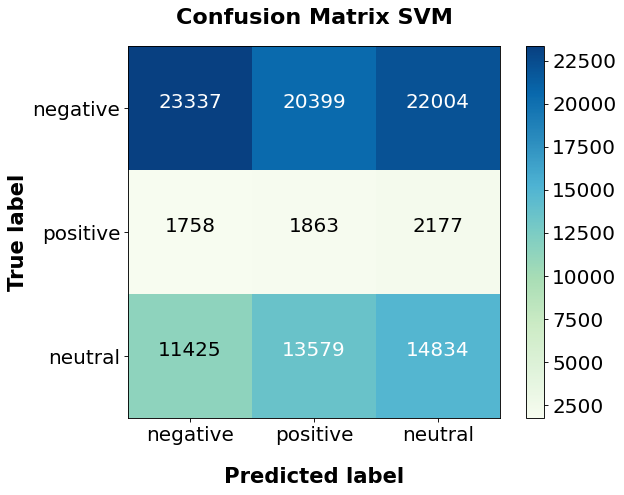

In [0]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

plot_confusion_matrix(cm_svm, classes=class_names,title='Confusion Matrix SVM',cmap='GnBu')

### f1 score

In [0]:
evaluator_svm = MulticlassClassificationEvaluator(labelCol="sentiment_ix", predictionCol="prediction")
f1_result = evaluator_svm.evaluate(predictions_svm)
f1_result

Out[343]: 0.40864293694466625

### save the model

In [0]:
model_svm.save("/FileStore/MLmodel_svm/")

##
<table>
<tr><td>

| |Random Forest|SVM|
|-|-|-|
|Accuracy|53%|36%|
|f1 score|53%|41%|
|Test Error|47%|64%|

</td></tr> </table>